In [20]:
import numpy as np 
import matplotlib.pyplot as plt
import io, pyopenlpt as lpt

redirector = lpt.PythonStreamRedirector()

import pybind11
from IPython.core.magic import register_cell_magic

@register_cell_magic
def skip(line, cell):
    print("⏭️ skipped this cell")
    # 什么都不执行，直接返回
    return

In [21]:
%%skip # skip this cell (comment this out if you want to run this cell)
# test bubble basic functions
import numpy as np
from scipy.io import loadmat

# read camera information
config_file = '../../test/inputs/test_STB_Bubble/config_python.txt'
basic_settings = lpt.BasicSetting()
basic_settings.readConfig(config_file)
cam_list = basic_settings._cam_list

# load synthetic data
data   = loadmat('../../test/inputs/test_STB_Bubble/data.mat')
tracks = data['tracks']
r_mm   = data['r_mm']           # shape: (N, 2) -> [id, radius_mm]
img_bb_ref = data['b_ref']

# --- robust ID→radius lookup (avoid float==float pitfalls) ---
ids = r_mm[:, 0].astype(int)
rs  = r_mm[:, 1].astype(float)
id_to_r = dict(zip(ids, rs))

bb1    = tracks[0, :3]
id_bb1 = int(round(tracks[0, 4]))     # ensure integer id
r_bb1  = float(id_to_r[id_bb1])       # scalar, no DeprecationWarning

# build object (scalar radius!)
obj_bb1 = lpt.Bubble3D(lpt.Pt3D(float(bb1[0]), float(bb1[1]), float(bb1[2])), r_bb1)
print(obj_bb1._pt_center, obj_bb1._r3d)

# 2D radius
with lpt.PythonStreamRedirector():
    obj_bb1.projectObject2D(cam_list)

r_bb1_check = lpt.Bubble.calRadiusFromOneCam(cam_list[0], obj_bb1._pt_center, obj_bb1._obj2d_list[0]._r_px)
r_bb1_check2 = lpt.Bubble.calRadiusFromCams(cam_list, obj_bb1._pt_center, obj_bb1._obj2d_list)
print(r_bb1, r_bb1_check, r_bb1_check2)

lptimg_bb_ref = lpt.Image.from_numpy(img_bb_ref.astype(np.uint8))
d_b = max(1, int(round(float(obj_bb1._obj2d_list[0]._r_px) * 2.0)))
resizer = lpt.BubbleResize()
img1_bb1 = resizer.ResizeBubble(lptimg_bb_ref, d_b, cam_list[0]._max_intensity)

arr = np.array(img1_bb1.to_list(), dtype=np.uint8)

# 画出来
plt.imshow(arr, cmap="gray", origin="upper")
plt.colorbar()
plt.title("Resized Bubble")
plt.show()


⏭️ skipped this cell


In [22]:
%%skip # skip this cell (comment this out if you want to run this cell)

# generate bubble synthetic image
# Generate synthetic bubble images (occlusion compositing)
# Inputs: tracks [x,y,z, frame_id, track_id], r_mm [track_id, radius_mm], img_bb_ref (template)
# Outputs:
#   ../../test/inputs/test_STB_Bubble/imgFile/cam{1..4}/img00000.tif
#   ../../test/inputs/test_STB_Bubble/imgFile/cam{1..4}ImageNames_python.txt

import os
import math
import numpy as np
from scipy.io import loadmat
from tifffile import imwrite

# ========= 路径 =========
ROOT = '../../test/inputs/test_STB_Bubble'
OUT_ROOT = os.path.join(ROOT, 'imgFile')
os.makedirs(OUT_ROOT, exist_ok=True)

# ========= 相机（均为 PINHOLE 且 active）=========
basic_settings = lpt.BasicSetting()
basic_settings.readConfig(os.path.join(ROOT, 'config_python.txt'))
cam_list = basic_settings._cam_list
n_cam = len(cam_list)
assert n_cam >= 1, "No camera found."

# ========= 数据 =========
data = loadmat(os.path.join(ROOT, 'data.mat'))
tracks = data['tracks']          # [x,y,z, frame_id, track_id]
r_mm   = data['r_mm']            # [track_id, radius_mm]
img_bb_ref_np = data['b_ref']    # 模板 (2D)

# TrackID -> 半径(mm)
ids = r_mm[:, 0].astype(int)
rs  = r_mm[:, 1].astype(float)
id_to_r = dict(zip(ids, rs))

# 模板转 lpt.Image
lptimg_bb_ref = lpt.Image.from_numpy(img_bb_ref_np.astype(np.uint8))

# ========= 工具 =========
def frame_to_name(fid: int) -> str:
    return f"img{int(fid):05d}.tif"

def ensure_cam_dirs(out_root: str, n_cam: int):
    ds = []
    for i in range(n_cam):
        d = os.path.join(out_root, f"cam{i+1}")
        os.makedirs(d, exist_ok=True)
        ds.append(d)
    return ds

def proj_ok(o2d) -> bool:
    u = o2d._pt_center[0]
    v = o2d._pt_center[1]
    return np.isfinite(u) and np.isfinite(v)

def valid_r(r_px) -> bool:
    return np.isfinite(r_px) and (r_px > 0.25)

def get_RT_for_cam(cam):
    """Xc = R*Xw + T（PINHOLE）；从 pinhole_param 取 r_mtx/t_vec"""
    p = cam._pinhole_param
    R = np.array(p.r_mtx.to_list(), dtype=float).reshape(3, 3)
    T = np.array(p.t_vec.to_list(),  dtype=float).reshape(3)
    return R, T

def cam_depth_Zc(cam, Xw_xyz):
    """返回 Zc；系统朝 +Z 看 → Zc 越大越远"""
    R, T = get_RT_for_cam(cam)
    Xw = np.array(Xw_xyz, dtype=float)
    Xc = R @ Xw + T
    return float(Xc[2])

def paste_cover_masked(canvas: np.ndarray, patch: np.ndarray, mask: np.ndarray, cx: int, cy: int):
    """
    遮挡合成：只在 mask=True 且 patch>0 的位置覆盖；自动裁剪越界
    canvas/patch: uint8, HxW
    """
    H, W = canvas.shape
    ph, pw = patch.shape
    x0 = cx - pw // 2; y0 = cy - ph // 2
    x1 = x0 + pw;      y1 = y0 + ph

    sx0 = max(0, x0); sy0 = max(0, y0)
    sx1 = min(W, x1); sy1 = min(H, y1)
    if sx0 >= sx1 or sy0 >= sy1:
        return

    px0 = sx0 - x0; py0 = sy0 - y0
    px1 = px0 + (sx1 - sx0); py1 = py0 + (sy1 - sy0)

    pr  = patch[py0:py1, px0:px1]
    mr  = mask [py0:py1, px0:px1]
    cr  = canvas[sy0:sy1, sx0:sx1]

    use = mr & (pr > 0)
    cr[use] = pr[use]

# 圆形掩膜缓存
mask_cache = {}
def get_circular_mask(d_b: int, patch_np: np.ndarray) -> np.ndarray:
    """
    生成与 patch 同尺寸的布尔圆掩膜（半径 ~ d_b/2），裁掉方形角落
    """
    key = (int(d_b), tuple(patch_np.shape))
    m = mask_cache.get(key)
    if m is None:
        ph, pw = patch_np.shape
        r = 0.5 * min(int(d_b), ph, pw)
        cy = (ph - 1) / 2.0
        cx = (pw - 1) / 2.0
        yy, xx = np.ogrid[:ph, :pw]
        m = ((xx - cx) ** 2 + (yy - cy) ** 2) <= (r * r)
        mask_cache[key] = m
    return m

# ========= 输出 =========
cam_dirs  = ensure_cam_dirs(OUT_ROOT, n_cam)
cam_lists = [[] for _ in range(n_cam)]

img_sizes  = [(cam.getNRow(), cam.getNCol()) for cam in cam_list]
max_intens = [float(cam._max_intensity) for cam in cam_list]

resizer = lpt.BubbleResize()
# 不同相机（幅值）与直径的补丁缓存
patch_cache = {}  # key: (icam, diameter_px) -> np.uint8 patch

all_frames = np.unique(tracks[:, 3].astype(int))
print(f"Total frames: {len(all_frames)}, cameras: {n_cam}")

# ========= 主循环 =========
for fi, fid in enumerate(all_frames):
    # 每相机一张空画布
    canvases = [np.zeros(sz, dtype=np.uint8) for sz in img_sizes]
    rows_f = tracks[tracks[:, 3].astype(int) == int(fid), :]

    # 为每个相机收集绘制项：(Zc, u, v, patch_np, mask_np)
    drawlists = [[] for _ in range(n_cam)]

    if rows_f.size > 0:
        for row in rows_f:
            x = float(row[0]); y = float(row[1]); z = float(row[2])
            tid = int(round(row[4]))
            R3D = float(id_to_r.get(tid, 0.0))
            if not (R3D > 0.0 and math.isfinite(R3D)):
                continue

            obj = lpt.Bubble3D(lpt.Pt3D(x, y, z), R3D)
            with lpt.PythonStreamRedirector():
                obj.projectObject2D(cam_list)

            for icam, cam in enumerate(cam_list):
                o2d = obj._obj2d_list[icam]
                if not proj_ok(o2d):
                    continue
                r_px = float(o2d._r_px)
                if not valid_r(r_px):
                    continue

                u = int(round(o2d._pt_center[0]))
                v = int(round(o2d._pt_center[1]))
                d_b = max(1, int(round(2.0 * r_px)))  # 直径（像素）

                key = (icam, d_b)
                if key not in patch_cache:
                    patch_img = resizer.ResizeBubble(lptimg_bb_ref, d_b, max_intens[icam])
                    patch_np  = np.array(patch_img.to_list(), dtype=np.uint8)
                    patch_cache[key] = patch_np
                else:
                    patch_np = patch_cache[key]

                mask_np = get_circular_mask(d_b, patch_np)
                Zc = cam_depth_Zc(cam, (x, y, z))
                if not np.isfinite(Zc):
                    continue

                drawlists[icam].append((Zc, u, v, patch_np, mask_np))

    # 画家算法：相机朝 +Z → Zc 从大到小（先远后近）
    for icam in range(n_cam):
        for Zc, u, v, patch_np, mask_np in sorted(drawlists[icam], key=lambda t: t[0], reverse=True):
            paste_cover_masked(canvases[icam], patch_np, mask_np, u, v)

        fname = frame_to_name(fid)
        save_path = os.path.join(cam_dirs[icam], fname)
        imwrite(save_path, canvases[icam])

        # 清单写相对路径（与你示例一致）
        rel_path = os.path.join(OUT_ROOT, f"cam{icam+1}", fname)
        cam_lists[icam].append(rel_path)

    if (fi + 1) % 10 == 0 or fi == 0:
        print(f"[{fi+1}/{len(all_frames)}] frame {fid} done (occlusion, circular mask).")

# ========= 写清单 =========
for icam in range(n_cam):
    list_txt = os.path.join(OUT_ROOT, f"cam{icam+1}ImageNames_python.txt")
    with open(list_txt, 'w', encoding='utf-8') as f:
        for p in cam_lists[icam]:
            f.write(p.replace("\\", "/") + "\n")
    print(f"Wrote {list_txt} ({len(cam_lists[icam])} lines)")

⏭️ skipped this cell


In [23]:
config_file = '../../test/inputs/test_STB_Bubble/config_python.txt'
basic_settings = lpt.BasicSetting()
basic_settings.readConfig(config_file)
cam_list = basic_settings._cam_list

from pprint import pprint

with lpt.PythonStreamRedirector():
    bb_cfg = lpt.BubbleConfig()
    bb_cfg.readConfig(basic_settings._object_config_paths[0], basic_settings)

# 子结构字段白名单
SUBFIELDS = {
    "IPRParam": [
        "n_cam_reduced", "n_loop_ipr", "n_loop_ipr_reduced", "n_obj2d_process_max"
    ],
    "PFParam": [
        "limit", "nx", "ny", "nz", "r",
        "nBin_x", "nBin_y", "nBin_z",
        "is_smooth", "sigma_x", "sigma_y", "sigma_z"
    ],
    "SMParam": [
        "match_cam_count", "idmap_cell_px", "tol_2d_px", "tol_3d_mm"
    ],
    "ShakeParam": [
        "_shake_width", "_n_shake_loop", "_thred_ghost", "_shakewidth_min", "_ratio_augimg"
    ],
    "STBParam": [
        "_radius_search_obj", "_n_initial_frames", "_radius_search_track"
    ],
}

# Config（派生 + 基类）的候选字段（存在就取）
CONFIG_CANDIDATES = [
    # BUbbleConfig 自身
    "_radius_min", "_radius_max", "_sense", "_bb_ref_img",
    # ObjectConfig 基类
    "_n_thread", "_stb_param", "_shake_param", "_pf_param", "_ipr_param", "_sm_param",
]

def _maybe_extract(obj):
    """递归展开已知的子结构；否则返回原值或字符串"""
    tname = type(obj).__name__
    if tname in SUBFIELDS:
        out = {}
        for name in SUBFIELDS[tname]:
            out[name] = getattr(obj, name)
        return out
    return obj  # 对未列白名单的类型（如 OTF）直接返回对象本身

def bubble_cfg_to_dict(bb_cfg):
    d = {}
    # 合并派生类 + 基类字段（存在就读）
    for name in CONFIG_CANDIDATES:
        if hasattr(bb_cfg, name):
            val = getattr(bb_cfg, name)
            d[name] = _maybe_extract(val)
    # kind 是只读属性
    d["kind"] = bb_cfg.kind
    return d

# 用法
pprint(bubble_cfg_to_dict(bb_cfg), sort_dicts=False, width=100)

{'_radius_min': 2,
 '_radius_max': 30,
 '_sense': 0.9,
 '_bb_ref_img': <pyopenlpt.BubbleRefImg object at 0x0000028D1DA5FCB0>,
 '_n_thread': 1,
 '_stb_param': {'_radius_search_obj': 0.4, '_n_initial_frames': 4, '_radius_search_track': 1.2},
 '_shake_param': {'_shake_width': 0.01,
                  '_n_shake_loop': 4,
                  '_thred_ghost': 0.1,
                  '_shakewidth_min': 0.0005,
                  '_ratio_augimg': 2},
 '_pf_param': {'limit': <pyopenlpt.AxisLimit object at 0x0000028D1E7E36B0>,
               'nx': 51,
               'ny': 51,
               'nz': 51,
               'r': 1.0,
               'nBin_x': 11,
               'nBin_y': 11,
               'nBin_z': 11,
               'is_smooth': True,
               'sigma_x': 1.0,
               'sigma_y': 1.0,
               'sigma_z': 1.0},
 '_ipr_param': {'n_cam_reduced': 1,
                'n_loop_ipr': 2,
                'n_loop_ipr_reduced': 2,
                'n_obj2d_process_max': 200000},
 '_sm_para

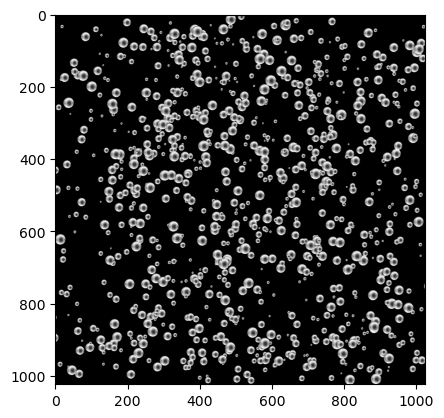

In [24]:
# create ImageIO instances for each image path
imgio_list = []
for path in basic_settings._image_file_paths:
    io = lpt.ImageIO()
    io.loadImgPath("", path)
    imgio_list.append(io)

num_cams = len(imgio_list)
frame_id = 0

image_list = []
for i in range(num_cams):
    image_list.append(imgio_list[i].loadImg(frame_id))

arr = np.array(image_list[0].to_list(), dtype=np.uint8)

plt.imshow(arr, cmap="gray")
plt.show()

Camera 0: found 842 objects.
Camera 1: found 846 objects.
Camera 2: found 792 objects.
Camera 3: found 807 objects.


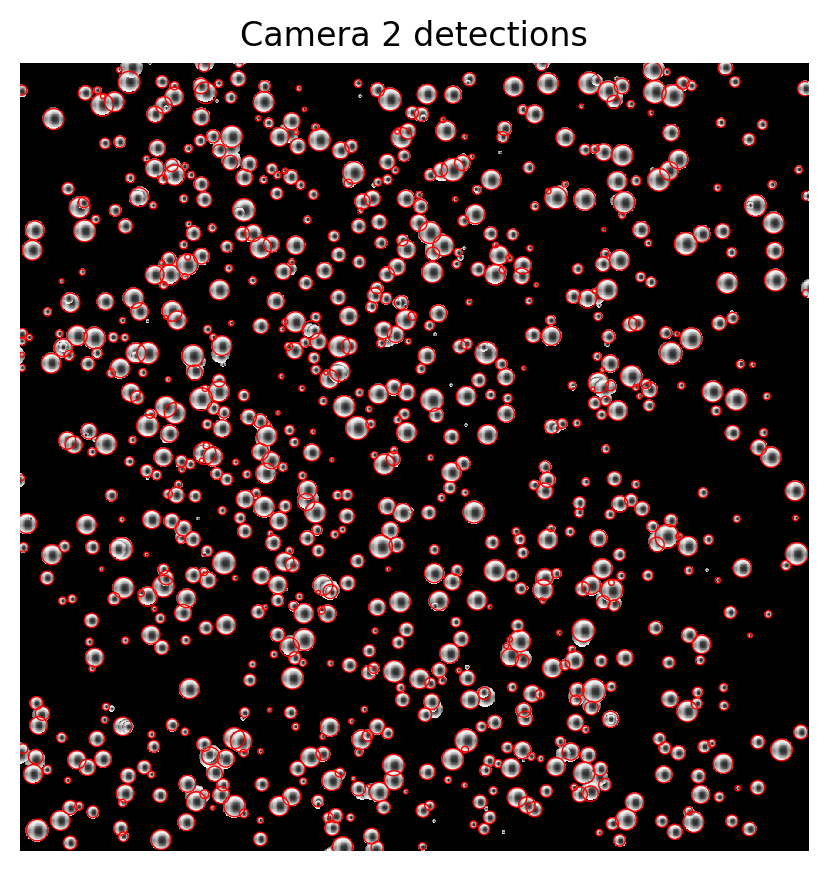

In [25]:
obj_finder = lpt.ObjectFinder2D()
n_cams = len(cam_list)
obj2d_list = []
for cam_id in range(n_cams):
    obj2ds = obj_finder.findObject2D(image_list[cam_id], bb_cfg)
    obj2d_list.append(obj2ds)
    print(f"Camera {cam_id}: found {len(obj2ds)} objects.")

from matplotlib.patches import Circle
from matplotlib.collections import PatchCollection

img = np.array(image_list[1].to_list(), dtype=np.uint8)
points = obj2d_list[1]

xs = [float(p._pt_center[0]) for p in points]
ys = [float(p._pt_center[1]) for p in points]
rs = [float(p._r_px)        for p in points] 

h, w = img.shape[:2]
dpi = 200
figsize = (w / dpi, h / dpi)

fig, ax = plt.subplots(figsize=figsize, dpi=dpi)
ax.imshow(img, cmap="gray", interpolation="none", origin="upper")

# 用 PatchCollection 一次性添加很多圆，效率更高
circles = [Circle((x, y), r) for x, y, r in zip(xs, ys, rs)]
pc = PatchCollection(
    circles,
    facecolor='none',       # 空心
    edgecolor='r',
    linewidths=0.5,
    antialiased=True
)
ax.add_collection(pc)

ax.set_title("Camera 2 detections")
ax.axis("off")
plt.show()

Matched 209 3D objects.
obj#0: total cams=4, valid 2D=4, cams=[0, 1, 2, 3]
obj#1: total cams=4, valid 2D=4, cams=[0, 1, 2, 3]
obj#2: total cams=4, valid 2D=4, cams=[0, 1, 2, 3]
obj#3: total cams=4, valid 2D=4, cams=[0, 1, 2, 3]
obj#4: total cams=4, valid 2D=4, cams=[0, 1, 2, 3]
obj#5: total cams=4, valid 2D=4, cams=[0, 1, 2, 3]
obj#6: total cams=4, valid 2D=4, cams=[0, 1, 2, 3]
obj#7: total cams=4, valid 2D=4, cams=[0, 1, 2, 3]
obj#8: total cams=4, valid 2D=4, cams=[0, 1, 2, 3]
obj#9: total cams=4, valid 2D=4, cams=[0, 1, 2, 3]
True
(33, 33)


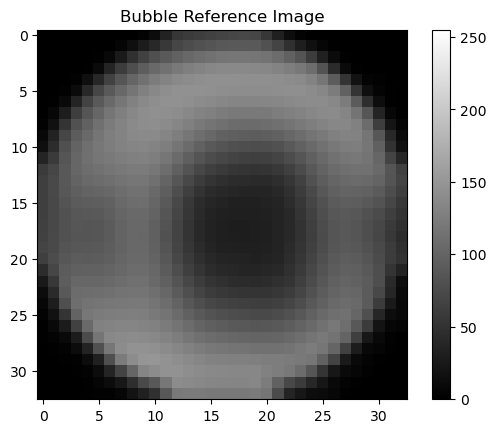

In [26]:
# test stereo matching
# to obtain bubble reference image, match camera number must equal to total camera number
bb_cfg._sm_param.match_cam_count = len(cam_list)
stereomath = lpt.StereoMatch(cam_list, obj2d_list, bb_cfg)
obj3d_list = stereomath.match()
print(f"Matched {len(obj3d_list)} 3D objects.")

# only match_cam_count cams have valid 2D projections
n_check = min(10, len(obj3d_list))

for i, obj in enumerate(obj3d_list[:n_check]):
    valid_cams = [c for c, o2d in enumerate(obj._obj2d_list) if o2d is not None]
    n_valid = len(valid_cams)
    print(f"obj#{i}: total cams={len(obj._obj2d_list)}, valid 2D={n_valid}, cams={valid_cams}")

# obtain bubble reference image
get_bb_img = bb_cfg._bb_ref_img.calBubbleRefImg(obj3d_list, obj2d_list, cam_list, image_list)
print(get_bb_img)

arr = np.array(bb_cfg._bb_ref_img[2].to_list(), dtype=np.uint8)
print(arr.shape)

# 画出来
plt.imshow(arr, cmap="gray", origin="upper", vmin=0, vmax=255)
plt.colorbar()
plt.title("Bubble Reference Image")
plt.show()

CameraType.PINHOLE


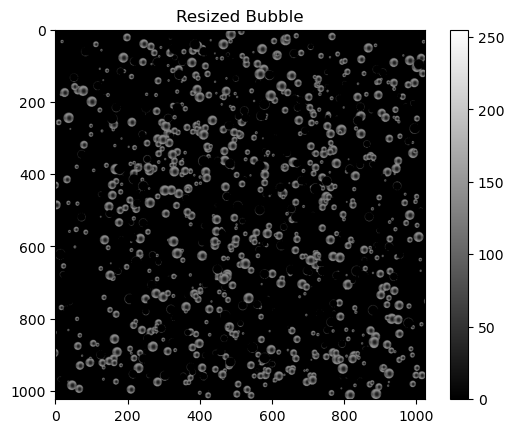

[True, True, True, True]
0.0 0.0


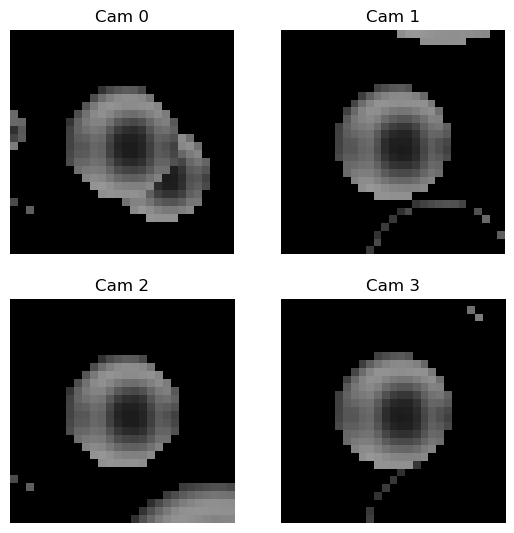

In [27]:
# test shake
shaker = lpt.Shake(cam_list, bb_cfg)
print(shaker.cams[0]._type)

for obj in obj3d_list:
    obj.projectObject2D(cam_list)

with lpt.PythonStreamRedirector():
    shaker.calResidueImage(obj3d_list, image_list)

img_res_1 = np.array(shaker.img_res_list[0].to_list(), dtype=np.int16)
img_res_1[img_res_1 < 0] = 0
arr = np.array(img_res_1, dtype=np.uint8)

# 画出来
plt.imshow(arr, cmap="gray", origin="upper", vmin=0, vmax=255)
plt.colorbar()
plt.title("Resized Bubble")
plt.show()

# pick one bubble to shake
bb1 = obj3d_list[0]
roi_all = shaker.buildROIInfo(bb1, image_list)

n_cam = len(image_list)
cols = min(2, n_cam)
rows = int(np.ceil(n_cam / cols))
fig, axes = plt.subplots(rows, cols, figsize=(3.2*cols, 3.2*rows))

# 让 axes 索引安全（兼容 1x1 / 1xn / nx1）
def get_ax(axes, r, c):
    if rows == 1 and cols == 1:
        return axes
    elif rows == 1:
        return axes[c]
    elif cols == 1:
        return axes[r]
    else:
        return axes[r, c]

for k in range(n_cam):
    ax = get_ax(axes, k // cols, k % cols)
    aug_img = roi_all[k].getAugImg()
    aug_img = np.array(aug_img.to_list(), dtype = np.uint8)
    ax.imshow(aug_img, cmap="gray", interpolation="nearest", origin="upper", vmin=0, vmax=255)
    ax.set_title(f"Cam {k}")
    ax.set_axis_off()

shake_cam = shaker.strategy.selectShakeCam(bb1, roi_all, image_list)
print(shake_cam)

delta = bb_cfg._shake_param._shake_width
xc = int(round(bb1._obj2d_list[0]._pt_center[0]))
yc = int(round(bb1._obj2d_list[0]._pt_center[1]))
d_b = int(bb1._obj2d_list[0]._r_px * 2 + 1)

resizer = lpt.BubbleResize()
ref_bb1 = resizer.ResizeBubble(bb_cfg._bb_ref_img[0], d_b, cam_list[0]._max_intensity)
img_bb1 = roi_all[0].getAugImg()
with lpt.PythonStreamRedirector():
    corr = shaker.strategy.getImgCorr(roi_all[0], xc, yc, ref_bb1)
    cx = xc - roi_all[0].ROI_range.col_min
    cy = yc - roi_all[0].ROI_range.row_min
    corr2 = lpt.myMATH.imgCrossCorrAtPt(img_bb1, ref_bb1, cx, cy)
print(corr, corr2)

In [ ]:
import pyopenlpt as lpt

config_file = '../../test/inputs/test_STB_Bubble/config_python.txt'
with lpt.PythonStreamRedirector():
    lpt.run(config_file)

**************
OpenLPT start!
**************

Initial phase at frame 0
START IPR...
Full cameras
Combination 0 cams=[0, 1, 2, 3]
		2D detections per active camera: 842  807  848  793   (0.40 s)
		Matched 396 objects. (0.01 s)	Obtained bubble reference image!	After shaking: 396 objects remain. (1.47 s)
	LOOP=0: TOTAL OBJECTS = 396
		2D detections per active camera: 578  587  539  527   (0.38 s)
		Matched 39 objects. (0.00 s)	After shaking: 38 objects remain. (0.34 s)
	LOOP=1: TOTAL OBJECTS = 434
Reduced cameras
Combination 0 cams=[0, 1, 2]
		2D detections per active camera: 546  560  501   (0.36 s)
		Matched 94 objects. (0.00 s)	After shaking: 92 objects remain. (0.41 s)
	LOOP=0: TOTAL OBJECTS = 526
Combination 1 cams=[0, 1, 3]
		2D detections per active camera: 487  498  513   (0.33 s)
		Matched 86 objects. (0.00 s)	After shaking: 86 objects remain. (0.39 s)
	LOOP=0: TOTAL OBJECTS = 612
Combination 2 cams=[0, 2, 3]
		2D detections per active camera: 417  464  441   (0.36 s)
		Matched 7